In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

def readImages(folder):
    images = []
    filenames = os.listdir(folder)
    for filename in tqdm(filenames, desc=f"Loading images from {folder}"):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (100, 100))
            images.append(img.flatten())
    return images

male_images = readImages('./maleeyes')
female_images = readImages('./femaleeyes')

male_labels = np.zeros(len(male_images))
female_labels = np.ones(len(female_images))


Loading images from ./femaleeyes: 100%|██████████| 5202/5202 [00:57<00:00, 90.28it/s] 


In [5]:
images = np.concatenate((male_images, female_images), axis=0)
labels = np.concatenate((male_labels, female_labels), axis=0)
eyes_df = pd.DataFrame({'image': images.tolist(), 'label': labels.astype(int)})


<span style="font-size:20px; color:Blue;">Exploratory Data </span>



In [6]:
eyes_df = eyes_df.sample(frac=1).reset_index(drop=True)


In [7]:
eyes_df.head()

,image,label
0,"[160, 189, 233, 161, 190, 234, 162, 191, 235, ...",1
1,"[122, 150, 211, 123, 151, 212, 125, 152, 214, ...",0
2,"[34, 46, 104, 33, 44, 102, 30, 42, 100, 31, 43...",1
3,"[133, 169, 215, 132, 168, 214, 130, 166, 212, ...",1
4,"[218, 225, 250, 219, 226, 251, 221, 228, 253, ...",1


In [8]:
eyes_df.shape

(11525, 2)

In [9]:
eyes_df.describe()

,label
count,11525.000000
mean,0.451367
std,0.497651
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
eyes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   11525 non-null  object
 1   label   11525 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 135.2+ KB


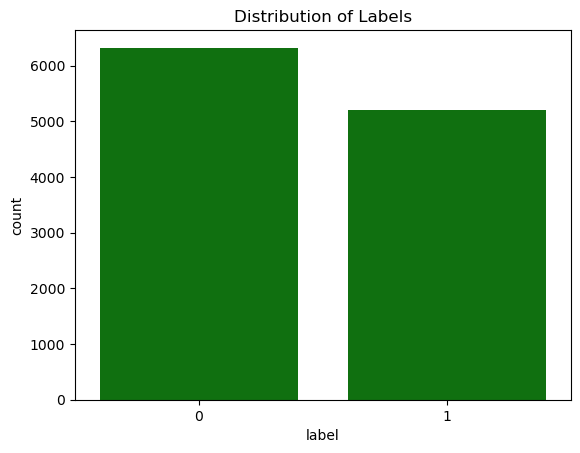

In [11]:

sns.countplot(x='label', data=eyes_df, color='green')
plt.title('Distribution of Labels')
plt.show()

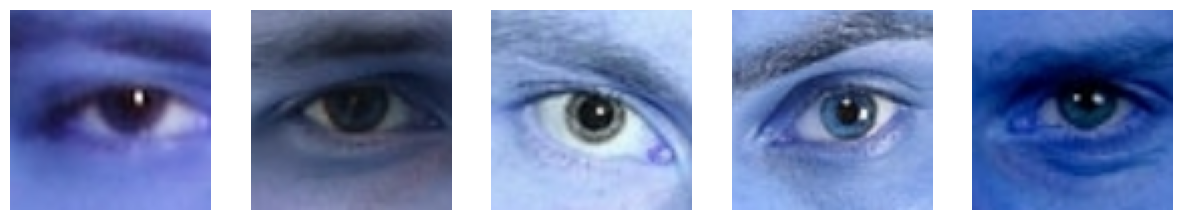

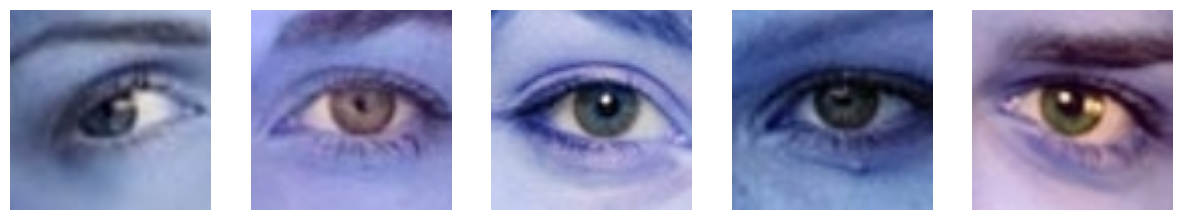

In [12]:

def display_sample_images(image_df, label, num_samples=5):
    sample_images = image_df[image_df['label'] == label].sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, (_, row) in enumerate(sample_images.iterrows()):
        img = np.array(row['image']).reshape(100, 100, 3)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

display_sample_images(eyes_df, label=0, num_samples=5)
display_sample_images(eyes_df, label=1, num_samples=5)


In [13]:
X = np.array(eyes_df['image'].tolist())
y = np.array(eyes_df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Till this point we imported the images, converted them into padas dataframe with labels 0 for male eyes and 1 for female eyes. After that we did some EVA and randomized the concatenated dataframe of male and female images.And, finally we splitted the data into training AND testing dataset.

<span style="font-size:20px; color:Blue;">2. Implement 3 classification models as below:
</span>



<span style="font-size:20px; color:Blue;">1. KNN Classifier
</span>



In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:

# List of n_neighbors to try
neighbors_list = [3, 5, 7, 10]

# Iterate over each value of n_neighbors and evaluate the model
for n_neighbors in neighbors_list:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train_scaled, y_train)
    y_pred = knn_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with n_neighbors={n_neighbors}: {accuracy}")
    print(f"Classification Report with n_neighbors={n_neighbors}:")
    print(classification_report(y_test, y_pred))
    print("\n" + "-"*60 + "\n")

Accuracy with n_neighbors=3: 0.8112798264642083
Classification Report with n_neighbors=3:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1300
           1       0.81      0.74      0.77      1005

    accuracy                           0.81      2305
   macro avg       0.81      0.80      0.81      2305
weighted avg       0.81      0.81      0.81      2305


------------------------------------------------------------

Accuracy with n_neighbors=5: 0.8199566160520607
Classification Report with n_neighbors=5:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1300
           1       0.84      0.73      0.78      1005

    accuracy                           0.82      2305
   macro avg       0.82      0.81      0.81      2305
weighted avg       0.82      0.82      0.82      2305


------------------------------------------------------------

Accuracy with n_neighbors=7: 0.829067245

We got the best accuracy when the number of neighbour is  7 among the provided number of neighbours with accuracy 0.83.

<span style="font-size:20px; color:Blue;">Model 2 - Multilayer Perceptron Model (do not use Sklearn Algorithms for the 
model)</span>



In [17]:
ml_model = Sequential([
    Input(shape=X_train[0].shape),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [18]:
ml_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [19]:
ml_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 30000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,848,449 (14.68 MB)

 Trainable params: 3,848,449 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

We can see that we have 1 input layer , 2 hidden layer in the middle and finally 1 output layer

In [34]:
#training the model
ml_history = ml_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2)


Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9776 - loss: 0.0625 - val_accuracy: 0.8975 - val_loss: 0.4280
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9833 - loss: 0.0492 - val_accuracy: 0.8991 - val_loss: 0.5025
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9759 - loss: 0.0658 - val_accuracy: 0.8888 - val_loss: 0.5886
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9791 - loss: 0.0688 - val_accuracy: 0.8926 - val_loss: 0.5212
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9678 - loss: 0.0923 - val_accuracy: 0.8932 - val_loss: 0.4938
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9786 - loss: 0.0642 - val_accuracy: 0.8894 - val_loss: 0.5105
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9793 - loss: 0.0650 - val_accuracy: 0.8872 - val_loss: 0.4729
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9816 - loss: 0.0524 - val_accu

In [35]:

y_p_ml = ml_model.predict(X_test)

y_p_ml = np.round(y_p_ml)


print(classification_report(y_test, y_p_ml))
test_accuracy = accuracy_score(y_test, y_p_ml)
print(f'Test Accuracy: {test_accuracy}')


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.13      0.23      1300
           1       0.47      0.99      0.64      1005

    accuracy                           0.51      2305
   macro avg       0.72      0.56      0.43      2305
weighted avg       0.75      0.51      0.41      2305

Test Accuracy: 0.5071583514099783


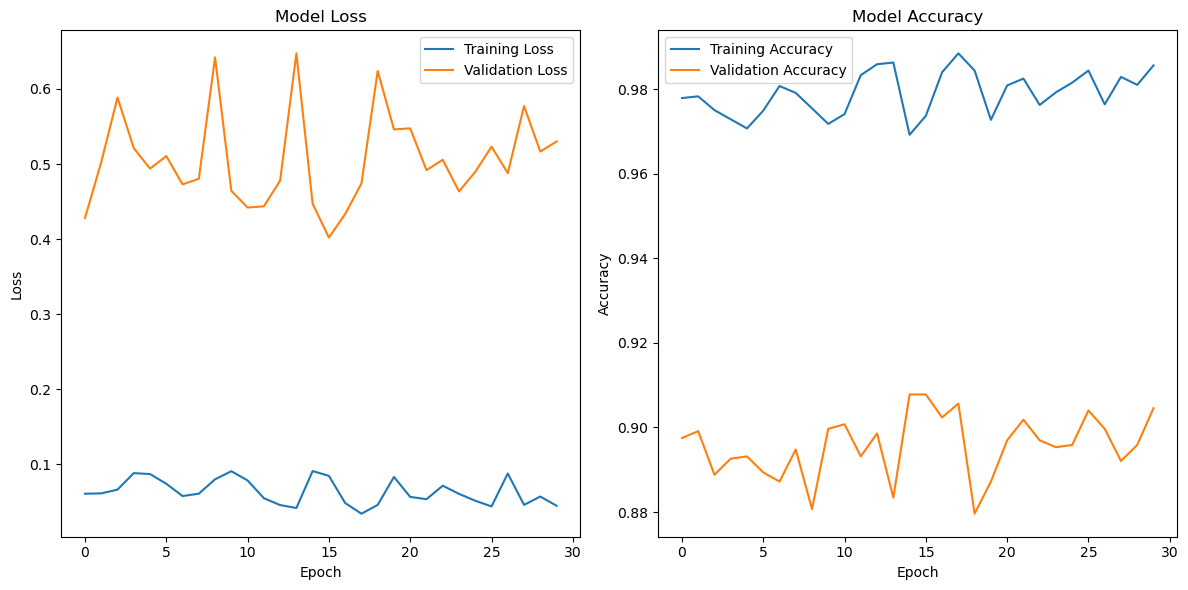

In [36]:
history_dict = ml_history.history

# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

From the graph, we can see that the training and validation loss both decreases as the number of epoch increases. And after 30 epoch the training and validation accuracy is almost 97% and 88% which seems to be better than the knn with 83% accuracy.

<span style="font-size:20px; color:Blue;"> Model 3 – CNN model
</span>



In [26]:

# Define the CNN model architecture with an additional hidden layer
cnn_model = Sequential([
    Input(shape=(100, 100, 3)),  # Define input shape here
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),  # Extra hidden layer
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [27]:
print(cnn_model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,361,409 (16.64 MB)

 Trainable params: 4,361,409 (16.64 MB)

 Non-trainable params: 0 (0.00 B)

None


The CNN model starts with images of size 100x100 with three color channels. It has two convolutional layers to find features in the images, each followed by pooling layers to make the images smaller and simpler. After that, the model flattens the features into a single line and processes them through two fully connected layers. Dropout layers are used to prevent overfitting by randomly ignoring some neurons during training. Finally, the model has an output layer that gives a single value between 0 and 1 for binary classification.

In [30]:
# Reshaping the scaled data to match the input shape of the CNN model
X_train_cnn = X_train_scaled.reshape(-1, 100, 100, 3)
X_test_cnn = X_test_scaled.reshape(-1, 100, 100, 3)

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnnHistory = cnn_model.fit(X_train_cnn, y_train, epochs=30, batch_size=64, validation_data=(X_test_cnn, y_test))

cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print("CNN Accuracy is ", cnn_accuracy)

Epoch 1/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.8707 - loss: 0.3183 - val_accuracy: 0.8963 - val_loss: 0.2508
Epoch 2/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.8948 - loss: 0.2590 - val_accuracy: 0.8902 - val_loss: 0.2876
Epoch 3/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 224ms/step - accuracy: 0.9120 - loss: 0.2200 - val_accuracy: 0.9098 - val_loss: 0.2316
Epoch 4/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.9130 - loss: 0.2039 - val_accuracy: 0.9189 - val_loss: 0.2186
Epoch 5/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - accuracy: 0.9326 - loss: 0.1731 - val_accuracy: 0.9176 - val_loss: 0.2176
Epoch 6/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 222ms/step - accuracy: 0.9489 - loss: 0.1303 - val_accuracy: 0.9124 - val_loss: 0.2188
Epoch 7/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.9485 - loss: 0.1301 - val_accuracy: 0.9111 - val_loss: 0.2507
Epoch 8/30
145/145 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9501 - loss: 0

In [31]:
# Prediction on test data
y_p_cnn = cnn_model.predict(X_test_cnn)
y_p_cnn = np.round(y_p_cnn).astype(int) 

print(classification_report(y_test, y_p_cnn))

73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1300
           1       0.88      0.93      0.91      1005

    accuracy                           0.92      2305
   macro avg       0.91      0.92      0.91      2305
weighted avg       0.92      0.92      0.92      2305



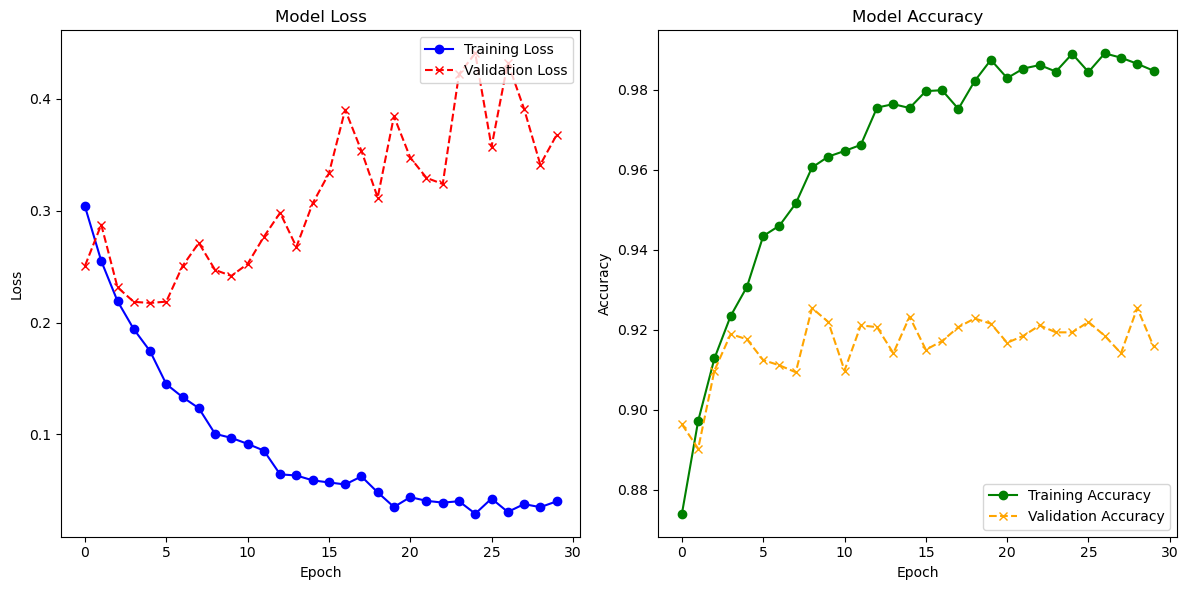

In [32]:

# Ploting training & validation loss
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(cnnHistory.history['loss'], color='blue', marker='o', linestyle='-', label='Training Loss')
plt.plot(cnnHistory.history['val_loss'], color='red', marker='x', linestyle='--', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plotting training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnnHistory.history['accuracy'], color='green', marker='o', linestyle='-', label='Training Accuracy')
plt.plot(cnnHistory.history['val_accuracy'], color='orange', marker='x', linestyle='--', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


From the above plot if you look at the training loss it is going down as the number of epoches increases but for validation dataset it increases as thhe number of epoches increases.

For the model accuracy, for thr training data it is almost 98% and for the validation data it is almost 91 % which is really good.

<span style="font-size:20px; color:Blue;"> 4. Compare the performance of the 3 models

</span>



For Knn :

Accuracy with n_neighbors=7: 0.8290672451193059
Classification Report with n_neighbors=7:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1300
           1       0.85      0.74      0.79      1005

    accuracy                           0.83      2305
   macro avg       0.83      0.82      0.82      2305
weighted avg       0.83      0.83      0.83      2305


for multilayer perceptron:

                  precision    recall  f1-score   support

           0       0.97      0.13      0.23      1300
           1       0.47      0.99      0.64      1005

    accuracy                           0.51      2305
   macro avg       0.72      0.56      0.43      2305
weighted avg       0.75      0.51      0.41      2305




for cnn:

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1300
           1       0.88      0.93      0.91      1005

    accuracy                           0.92      2305
   macro avg       0.91      0.92      0.91      2305
weighted avg       0.92      0.92      0.92      2305


Frm the classsification metrices,

The CNN model outperforms the other models with the highest accuracy of 0.92 and strong performance across both classes. It provides the best balance between precision and recall. The KNN model also performs well, achieving an accuracy of 0.83 with balanced results, though it falls short compared to CNN. In contrast, the MLP model has the lowest accuracy at 0.51 and struggles with poor recall for one of the classes, resulting in overall weaker performance.


<span style="font-size:20px; color:Blue;"> 5. Conclusions
</span>



In this project, we tested three models for predicting gender from eye images. CNNs are great for images because they can capture detailed patterns and structures. MLPs are more general but don’t handle images as well. KNN classifiers are simple and work well with clear and separate classes but are less effective with complex, multi-dimensional image data.

Overall, CNNs performed best for this image dataset.